In [39]:
import pandas as pd,numpy as np
from sklearn.cluster import DBSCAN
from ai_patterns_mining import Config
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from ai_patterns_mining import parse_json_safe
import getpass,os
from langchain.chat_models import init_chat_model
from tqdm import tqdm

In [2]:
config = Config(tag="prompt & rag",run_output="20251028_085918 - Run ")

In [3]:
data = pd.read_csv(config.PATTERN_EMBEDDINGS_FILE)

In [4]:
data.shape

(349, 3078)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,3068,3069,3070,3071,Pattern Name,Problem,Context,Solution,Result,Uses
0,-0.018883,0.018348,0.015192,-0.064823,0.009560,-0.000574,0.007251,0.018905,0.010347,0.005121,...,-0.024357,-0.008189,0.007308,-0.005529,External Knowledge Augmentation,Large Language Models (LLMs) are bounded by th...,LLMs relying on fixed and parametric knowledge...,Augment LLMs with the capability to access ext...,LLMs can surpass traditional knowledge limitat...,"Accessing contemporary information, retrieving..."
1,-0.008191,0.003771,0.017525,-0.069466,0.005526,0.004902,0.018165,0.018313,0.009491,-0.005704,...,-0.018045,-0.007270,-0.003900,-0.009526,Domain-Specific Tool Integration,"LLMs, trained on general knowledge, often exhi...",LLMs needing to perform tasks requiring deep e...,Employ specific external tools like online cal...,"Mitigates the expertise gap in LLMs, enhancing...","Performing complex calculations, solving equat..."
2,-0.001247,0.011756,0.010845,-0.064622,0.007938,-0.014040,0.001880,0.026454,-0.003862,-0.004009,...,-0.012774,-0.009557,-0.001842,-0.003681,Task Automation via Tools,LLMs are fundamentally language processors and...,Users requiring LLMs to perform real-world act...,Integrate LLMs with external task automation t...,LLMs can facilitate the execution of external ...,"Scheduling appointments, setting reminders, fi..."
3,-0.025640,0.017146,0.008126,-0.085418,0.008393,0.001277,-0.006190,0.023205,0.011792,-0.012512,...,-0.016213,-0.006697,-0.011836,-0.025644,Multimodal Interaction Augmentation,LLMs often struggle to consistently understand...,User interactions involving varied input types...,Deploy specialized tools like speech recogniti...,Improved understanding and response to a broad...,"Understanding speech inputs, analyzing images,..."
4,-0.027161,0.018188,0.022234,-0.068988,0.008201,-0.013026,-0.015420,0.039391,0.007960,0.003362,...,-0.007785,-0.010598,0.009240,0.006855,Transparent Tool-Use Reasoning,The opaque 'black-box' nature of current LLMs ...,"LLM applications where interpretability, accou...",Utilize tool learning to enable LLMs to exhibi...,"More transparent LLM operations, allowing user...","Explaining complex problem-solving steps, debu..."


In [24]:
pattern_cols = ["Pattern Name","Problem","Context","Solution","Result","Uses"]
features_cols = [i for i in data.columns.tolist() if i not in pattern_cols]
embeddings = data[features_cols]
Y = data["Pattern Name"].tolist()

### PCA & Analysis

In [7]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

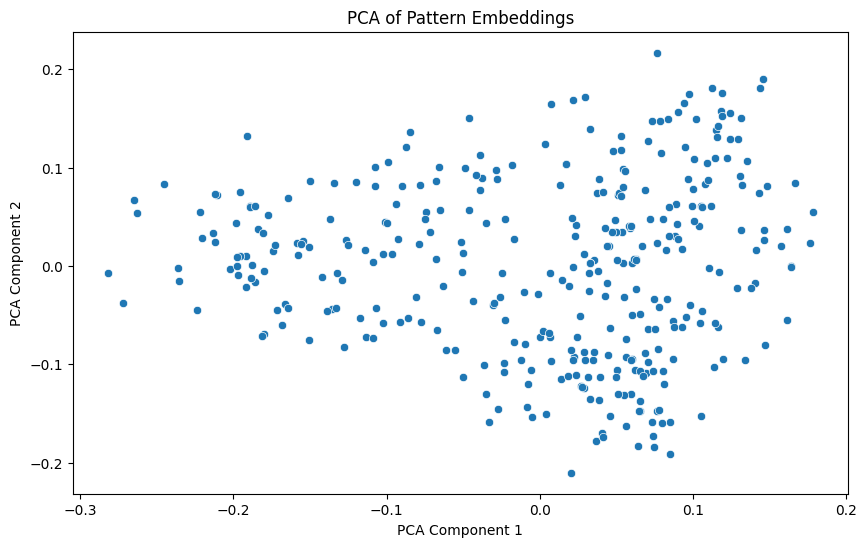

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1])
plt.title("PCA of Pattern Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [9]:
emb_umap = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(embeddings)

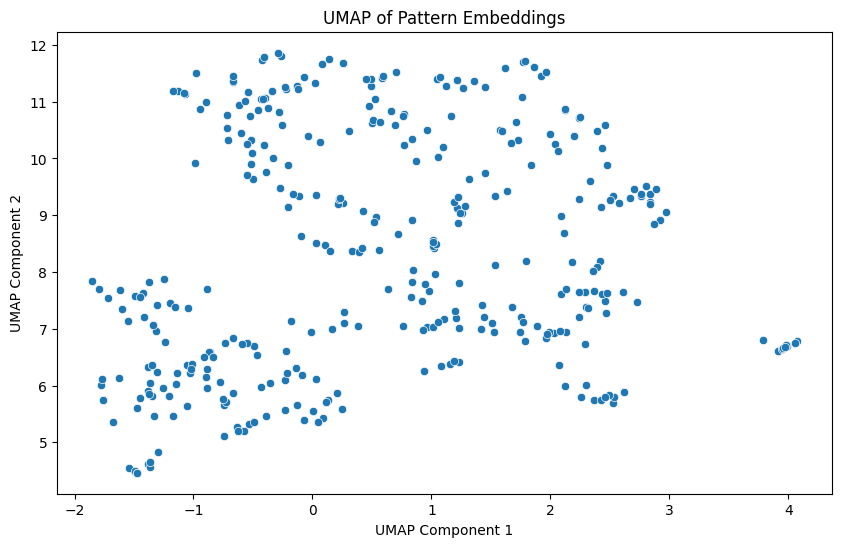

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=emb_umap[:,0], y=emb_umap[:,1])
plt.title("UMAP of Pattern Embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

### Compare patterns using LLMs

In [11]:

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)


In [101]:
pattern_comparing_prompt = """\
You are an expert in AI design pattern analysis and comparison.

Compare the following two AI design patterns and determine whether to keep, remove, or combine them. 
Focus on identifying overlap, uniqueness, and usefulness in practical AI system design.

Pattern 01:
{pattern1}

Pattern 02:
{pattern2}

Respond strictly in the following JSON format:

  "remove": "pattern 01" | "pattern 02" | "both" | "none",
  "can_combine": true | false,
  "combined_pattern_suggestion":
    "Pattern Name": "<string>",
    "Problem": "<string>",
    "Context": "<string>",
    "Solution": "<string>",
    "Result": "<string>",
    "Uses": "<string>"
  ,
  "think": "<reasoning for the decision>"

**Decision rules:**
- If both patterns are valuable and distinct → `"remove": "none"`, `"can_combine": false`.
- If both patterns describe the same thing but one is more comprehensive → remove the less useful one. => `"remove": "pattern 01"` or `"remove": "pattern 02"`. can_combine: false.
- If one pattern is redundant or weaker → remove the less useful one.
- If both are address same concept in different ways and can merge into a stronger unified pattern → `"remove": "both"`, `"can_combine": true`.
- If both solve different problems or contexts → `"remove": "none"`.
- Prefer keeping existing patterns rather than creating new combined ones.
- Only include `combined_pattern_suggestion` if `"can_combine": true`; otherwise, leave it empty or omit it.
- Do not include any explanation outside the JSON output.

"""

In [102]:
def compare_patterns(pattern1, pattern2):
    log_file = "./logs/pattern_comparison_log.txt"
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    f = open(log_file,"a")
    f.write("="*100+f"\nComparing Patterns:\nPattern 01: {pattern1}\nPattern 02: {pattern2}\n")
    prompt = pattern_comparing_prompt.format(pattern1=pattern1, pattern2=pattern2)
    response = llm.invoke(prompt)
    f.write(f"LLM Response: {response.content}\n\n")
    return parse_json_safe(response.content,delimiter="{}")

In [91]:
def df_to_pattern_dict(df):
    return {
        "Pattern Name": df["Pattern Name"].values[0],
        "Problem": df["Problem"].values[0],
        "Context": df["Context"].values[0],
        "Solution": df["Solution"].values[0],
        "Result": df["Result"].values[0],
        "Uses": df["Uses"].values[0],
    }

#### Distance Measures

In [15]:
distances = pairwise_distances(embeddings, metric='cosine')
print("Min distance:", np.min(distances)
      ,"\nMax distance:", np.max(distances)
      ,"\nMean distance:", np.mean(distances)
      ,"\nMedian distance:", np.median(distances)
)

Min distance: 0.0 
Max distance: 0.2780125214798457 
Mean distance: 0.1631950130497539 
Median distance: 0.16427057184685367


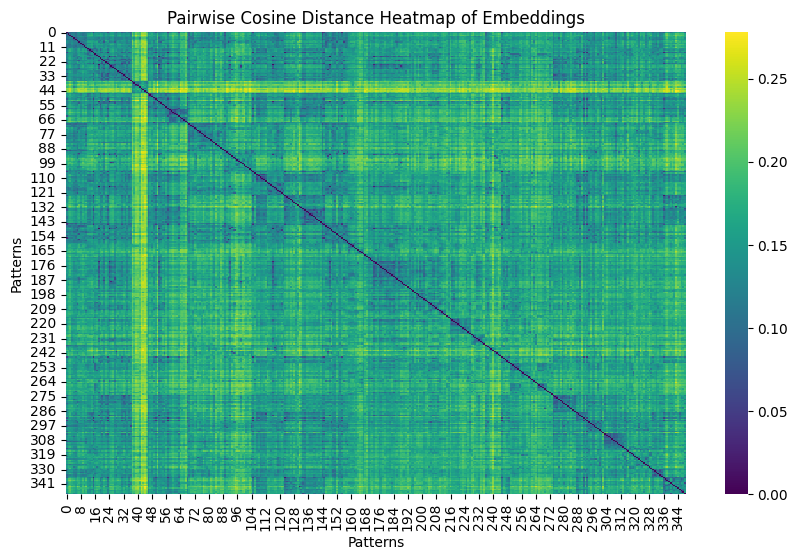

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(distances, cmap='viridis')
plt.title('Pairwise Cosine Distance Heatmap of Embeddings')
plt.xlabel('Patterns')
plt.ylabel('Patterns')
plt.show()

In [50]:
removable_indices = set()
new_patterns = []

In [114]:
embeddings = data[features_cols]
pattern_data = data[pattern_cols]

In [115]:
embeddings = embeddings.drop(removable_indices, axis=0).reset_index(drop=True)
distances = pairwise_distances(embeddings, metric='cosine')

In [117]:
print(embeddings.shape)
print(distances.shape)
print(pattern_data.shape)

(349, 3072)
(349, 349)
(349, 6)


In [106]:
def remove_pattern(pattern_index):
    global embeddings, pattern_data
    embeddings = embeddings.drop(pattern_index, axis=0).reset_index(drop=True)
    pattern_data = pattern_data.drop(pattern_index, axis=0).reset_index(drop=True)

In [ ]:
distance_threshold = 0.03
distance_threshold_llm = 0.08
break_point = 5
for i, row in tqdm(enumerate(distances),desc="Comparing Patterns"):

    print(i,"Pattern: ", end="")
    print(pattern_data.iloc[i]["Pattern Name"], end=" --> ")
    print(np.argsort(row)[1],pattern_data.iloc[np.argsort(row)[1]]["Pattern Name"], f"(Distance: {row[np.argsort(row)[1]]:.4f})")

    if row[np.argsort(row)[1]] > distance_threshold or i in removable_indices or np.argsort(row)[1] in removable_indices:     
        if row[np.argsort(row)[1]] <= distance_threshold_llm:
            pattern_01_df,pattern_02_df = pd.DataFrame(columns=pattern_cols, data=[pattern_data.iloc[i]]), pd.DataFrame(columns=pattern_cols, data=[pattern_data.iloc[np.argsort(row)[1]]])
            pattern_01_dict,pattern_02_dict = df_to_pattern_dict(pattern_01_df),df_to_pattern_dict(pattern_02_df)
            print("Comparing patterns are:\n", pattern_01_dict, "\n", pattern_02_dict)
            result = compare_patterns(pattern_01_dict, pattern_02_dict)
            if result.get("remove") == "pattern 01":
                removable_indices.add(i)
            elif result.get("remove") == "pattern 02":
                removable_indices.add(int(np.argsort(row)[1]))
            elif result.get("remove") == "both":
                removable_indices.add(i)
                removable_indices.add(int(np.argsort(row)[1]))
            
            if result.get("can_combine") == True:
                new_patterns.append(result.get("combined_pattern_suggestion"))

            # if break_point <= 0:
            #     break
            # break_point -= 1
        continue
    removable_indices.add(int(np.argsort(row)[1]))
remove_pattern(removable_indices)
distances = pairwise_distances(embeddings, metric='cosine')
removable_indices = set()

Comparing Patterns: 0it [00:00, ?it/s]

0 Pattern: External Knowledge Augmentation --> 155 Knowledge Augmentation (Distance: 0.0274)
1 Pattern: Domain-Specific Tool Integration --> 144 Tool Augmentation (Distance: 0.0659)
Comparing patterns are:
 {'Pattern Name': 'Domain-Specific Tool Integration', 'Problem': 'LLMs, trained on general knowledge, often exhibit deficiencies in specialized domains such as complex mathematics, code generation, chemistry, biology, economics, or medicine.', 'Context': 'LLMs needing to perform tasks requiring deep expertise or precise calculations beyond their general training data.', 'Solution': "Employ specific external tools like online calculators, Python interpreters, or specialized scientific/economic/medical tools to augment the LLMs' domain-specific expertise.", 'Result': 'Mitigates the expertise gap in LLMs, enhancing their utility in specialized applications by providing access to domain-specific knowledge and computational capabilities.', 'Uses': 'Performing complex calculations, solving

Comparing Patterns: 2it [00:26, 13.01s/it]

2 Pattern: Task Automation via Tools --> 89 Tool Use / Tool Augmentation (Distance: 0.0728)
Comparing patterns are:
 {'Pattern Name': 'Task Automation via Tools', 'Problem': 'LLMs are fundamentally language processors and lack the inherent capability to execute external actions independently, such as reserving conference rooms or booking flight tickets.', 'Context': 'Users requiring LLMs to perform real-world actions or automate repetitive tasks that involve interacting with external systems.', 'Solution': 'Integrate LLMs with external task automation tools, scheduling tools, project management tools, online shopping assistants, or data table processing tools by populating their interfaces with the necessary parameters.', 'Result': 'LLMs can facilitate the execution of external actions, automate repetitive tasks (e.g., scheduling, setting reminders, filtering emails), and enhance practical user assistance, efficiency, and user experience.', 'Uses': 'Scheduling appointments, setting rem

Comparing Patterns: 3it [00:47, 16.55s/it]

3 Pattern: Multimodal Interaction Augmentation --> 144 Tool Augmentation (Distance: 0.0834)
4 Pattern: Transparent Tool-Use Reasoning --> 150 In-Context Learning for Tool Use (Distance: 0.0852)
5 Pattern: Robust Tool-Augmented Processing --> 144 Tool Augmentation (Distance: 0.0732)
Comparing patterns are:
 {'Pattern Name': 'Robust Tool-Augmented Processing', 'Problem': 'LLMs are highly sensitive to user inputs, where minor modifications can elicit substantial changes in responses, highlighting a lack of robustness. Additionally, external tools introduce new safety concerns like adversarial attacks on tool outputs.', 'Context': 'Real-world applications with diverse and potentially noisy user inputs, and the need for stable, reliable, and secure LLM performance.', 'Solution': 'Integrate specialized tools to reduce reliance on the statistical patterns in training data, as tools provide a consistent input/output interface. Implement rigorous validation of tool outputs and mechanisms to det

Comparing Patterns: 6it [01:08, 10.32s/it]

6 Pattern: Iterative Task Solving (with Feedback) --> 149 Self-Correction / Feedback Loop (Distance: 0.0688)
Comparing patterns are:
 {'Pattern Name': 'Iterative Task Solving (with Feedback)', 'Problem': 'A single-pass approach to tool learning, where a complete task plan is committed upfront, struggles with errors, uncertainties, and the need for dynamic adjustments based on real-time tool feedback.', 'Context': 'Complex tasks where initial plans may be incomplete or incorrect, and the environment or tool outputs are dynamic or unpredictable.', 'Solution': 'Adopt a paradigm where the LLM does not commit to a complete task plan upfront. Instead, it iteratively interacts with tools, adjusting subtasks and refining its plan progressively based on feedback from tool execution (e.g., error messages, unexpected results).', 'Result': 'Improved problem-solving capabilities, greater robustness, and enhanced adaptability to dynamic environments, allowing LLMs to address problems step-by-step, r

Comparing Patterns: 7it [01:31, 13.37s/it]

7 Pattern: Task Decomposition and Planning --> 156 Task Decomposition (Distance: 0.0470)
Comparing patterns are:
 {'Pattern Name': 'Task Decomposition and Planning', 'Problem': 'User queries in real-world scenarios often embody complex intent that cannot be directly addressed by a single LLM response or a single tool invocation.', 'Context': 'A complex user question requiring multi-step actions and reasoning, where the LLM needs to orchestrate multiple operations.', 'Solution': "The LLM analyzes the user's intent, decomposes the complex query into multiple solvable subquestions, and delineates the dependency relationships and execution sequence among these subtasks. This can be achieved through tuning-free methods (e.g., CoT, ReACT, prompt design) or tuning-based methods.", 'Result': 'A structured plan of action that breaks down a complex problem into manageable, sequential or parallel subtasks, enabling the LLM to systematically address the overall query and prepare for subsequent too

Comparing Patterns: 8it [01:50, 14.71s/it]

8 Pattern: Tool Retrieval and Selection --> 146 Tool Orchestration / Chaining (Distance: 0.0867)
9 Pattern: Parameter Extraction and Tool Invocation --> 146 Tool Orchestration / Chaining (Distance: 0.0831)
10 Pattern: Tool-Augmented Response Synthesis --> 144 Tool Augmentation (Distance: 0.0878)
11 Pattern: LLM as Tool Maker/Creator --> 77 AI Tool Creation (Distance: 0.0621)
Comparing patterns are:
 {'Pattern Name': 'LLM as Tool Maker/Creator', 'Problem': 'Manually creating a comprehensive, diverse, and high-quality set of tools for LLMs is resource-intensive and limits the scalability and applicability of tool learning. Existing tools often suffer from quality issues, limited accessibility, and varied description formats.', 'Context': 'To fully leverage the potential of tool-augmented LLMs, a vast and adaptable tool ecosystem is required. The overhead of human-driven tool development hinders rapid expansion and standardization.', 'Solution': 'Employ Large Language Models (LLMs) themse

Comparing Patterns: 11it [02:11, 11.91s/it]


In [ ]:
# 15 Pattern: Retrieval Augmented Generation (RAG) --> 123 Retrieval Augmented Generation (RAG) (Distance: 0.0199)
# 18 Pattern: Chain of Thought (CoT) Prompting --> 116 Chain-of-Thought (CoT) Prompting (Distance: 0.0097)
# 148 Pattern: Chain-of-Thought (CoT) Prompting --> 18 Chain of Thought (CoT) Prompting (Distance: 0.0118)

set()

In [57]:
new_patterns

[{'Pattern Name': 'External Knowledge Augmentation',
  'Problem': 'Large Language Models (LLMs) are bounded by their pretraining knowledge, lack the ability to acquire updated or domain-specific information, and are prone to generating factually inaccurate or outdated content (hallucination).',
  'Context': 'LLMs rely on vast but static pre-trained corpora and fixed parametric knowledge, often struggling with contemporary, specific, or domain-specific factual queries. Many tasks require access to dynamic, external, or specialized knowledge sources.',
  'Solution': 'Augment LLMs with the capability to access and integrate explicit external knowledge sources and tools, such as search engines, structured databases, knowledge graphs, specialized APIs, or real-time data feeds, to dynamically acquire and incorporate up-to-date and relevant information.',
  'Result': 'LLMs can surpass traditional knowledge limitations, offering more accurate, contextually relevant, and factually grounded outp

### Clustering

In [113]:
dbscan = DBSCAN(eps=0.08, min_samples=1, metric='cosine')
clusters = dbscan.fit_predict(embeddings)
len(set(clusters.tolist()))

179

In [111]:
for i,row in enumerate(clusters):
    print(f"{i} Pattern: {Y[i]} --> Cluster: {row}")

0 Pattern: External Knowledge Augmentation --> Cluster: 0
1 Pattern: Domain-Specific Tool Integration --> Cluster: 0
2 Pattern: Task Automation via Tools --> Cluster: 0
3 Pattern: Multimodal Interaction Augmentation --> Cluster: 1
4 Pattern: Transparent Tool-Use Reasoning --> Cluster: 2
5 Pattern: Robust Tool-Augmented Processing --> Cluster: 0
6 Pattern: Iterative Task Solving (with Feedback) --> Cluster: 3
7 Pattern: Task Decomposition and Planning --> Cluster: 0
8 Pattern: Tool Retrieval and Selection --> Cluster: 4
9 Pattern: Parameter Extraction and Tool Invocation --> Cluster: 5
10 Pattern: Tool-Augmented Response Synthesis --> Cluster: 6
11 Pattern: LLM as Tool Maker/Creator --> Cluster: 7
12 Pattern: Sufficient Context Autorater --> Cluster: 8
13 Pattern: Selective Generation with Sufficient Context Signal --> Cluster: 8
14 Pattern: Finetuning for Controlled Abstention --> Cluster: 8
15 Pattern: Retrieval Augmented Generation (RAG) --> Cluster: 0
16 Pattern: LLM-based Evaluatio